In [1]:
from pyincore import IncoreClient
from pyincore import GeoUtil
from pyincore import FragilityService, MappingSet, Dataset, DataService
from pyincore_viz.geoutil import GeoUtil as viz
from pyincore_viz.plotutil import PlotUtil as plot
from pyincore import FragilityCurveSet, FragilityService
from pyincore.hazardservice import HazardService
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.capitalshocks import CapitalShocks
from pyincore.analyses.joplincge import JoplinCGEModel
from pyincore.analyses.montecarlofailureprobability import MonteCarloFailureProbability 
import numpy as np
import copy
import math
import os
import json
import pandas as pd
import csv
import warnings
os.chdir("/Users/yunjiewen/Desktop/Joplin_Analysis_paper_Part2/Tornado_simulation/Joplin_EF2_tornado")
warnings.filterwarnings('ignore')

In [2]:
client = IncoreClient()  # The authentication service validates username/password and
                         # approves users to access to other services."https://incore-dev.ncsa.illinois.edu"
client.clear_cache()

Enter username: yunjie00
Enter password: ········
Enter username: yunjie00
Enter password: ········
Connection successful to IN-CORE services. pyIncore version detected: 1.0.0


In [3]:
def building_damage_without_retrofit(hazard_id,fragilityMappingSet):
    """
    This funciton is to calculate the building damage without retrofitting implemented
    from a troando event by using INCORE service
    input:
    hazard: INCORE hazard id
    fragilityMappingSet: INCORE fragility Mapping data
    Return:
    building_dmg_result: INCORE data type of building damage result 
    df_building_dmg: dataframe of building damage result
    
    """
    
    bldg_dmg = BuildingDamage(client)

    # result name
    result_name = "tornado_dmg_result_no_retrofit" + hazard_id
    # building damage analysis through INCORE service
    bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
    bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set_no_retrofit)
    bldg_dmg.set_parameter("fragility_key", "Non-Retrofit Fragility ID Code") # without retrofitting, check the Mapping object
    bldg_dmg.set_parameter("result_name", result_name)
    bldg_dmg.set_parameter("hazard_type", hazard_type)
    bldg_dmg.set_parameter("hazard_id", hazard_id)
    bldg_dmg.set_parameter("num_cpu", 4)
    bldg_dmg.run_analysis()

    
    #results
    building_dmg_result = bldg_dmg.get_output_dataset('ds_result')
    # Convert dataset to Pandas DataFrame
    df_building_dmg = building_dmg_result.get_dataframe_from_csv()
    
    return  building_dmg_result,df_building_dmg

In [4]:
def building_damage_with_retrofit(hazard_id,fragilityMappingSet,retrofit_data,retrofit_level):
    """
    This funciton is to calculate the building damage with retrofitting implemented
    from a troando event by using INCORE service
    input:
    hazard: INCORE hazard id
    fragilityMappingSet: INCORE fragility Mapping data
    retrofit_data: INCORE dataset of retrofit data
    retrofit_level: string, retrofit level
    Return:
    building_dmg_result: INCORE data type of building damage result 
    df_building_dmg: dataframe of building damage result
    
    """
    
    bldg_dmg = BuildingDamage(client)

    # result name
    result_name = "tornado_dmg_result_retrofit" + retrofit_level
    # building damage analysis through INCORE service
    bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
    bldg_dmg.set_input_dataset("retrofit_strategy", retrofit_data)
    bldg_dmg.set_input_dataset('dfr3_mapping_set', mapping_set_with_retrofit)
    bldg_dmg.set_parameter("fragility_key", "Fragility ID Code") # use it when use retrofit mapping
    bldg_dmg.set_parameter("result_name", result_name)
    bldg_dmg.set_parameter("hazard_type", hazard_type)
    bldg_dmg.set_parameter("hazard_id", hazard_id)
    bldg_dmg.set_parameter("num_cpu", 4)
    bldg_dmg.run_analysis()

    #results
    building_dmg_result = bldg_dmg.get_output_dataset('ds_result')
    # Convert dataset to Pandas DataFrame
    df_building_dmg = building_dmg_result.get_dataframe_from_csv()
    
    return  building_dmg_result,df_building_dmg

In [5]:
def MC_building_damage(number_samples,building_dmg_result):
    """
    This function is to calculte the building damage using Metro Carlo simulation
    input:
    retrofit_level: integer, simulation sample numnber
    building_dmg_result: INCORE datatype, building damage result
    
    Return:
    building_failure_probability: INCORE datatype of building failure results
    df_bldg_fail: dataframe, building failure results
    
    """
    
    mc_bldg = MonteCarloFailureProbability(client)
    
    num_samples = number_samples
    result_name = "tornado_mc_failure_probability_buildings"
    
    mc_bldg.set_input_dataset("damage", building_dmg_result)                                                          
    mc_bldg.set_parameter("num_cpu", 8)
    mc_bldg.set_parameter("num_samples", num_samples)
    mc_bldg.set_parameter("damage_interval_keys", ["DS_0", "DS_1", "DS_2", "DS_3"])
    mc_bldg.set_parameter("failure_state_keys", ["DS_1", "DS_2", "DS_3"])
    mc_bldg.set_parameter("result_name", result_name) 
    mc_bldg.run_analysis()
    # resulrts
    building_failure_probability = mc_bldg.get_output_dataset('failure_probability')  # get buildings failure probabilities
    df_bldg_fail = building_failure_probability.get_dataframe_from_csv()
    return building_failure_probability,df_bldg_fail

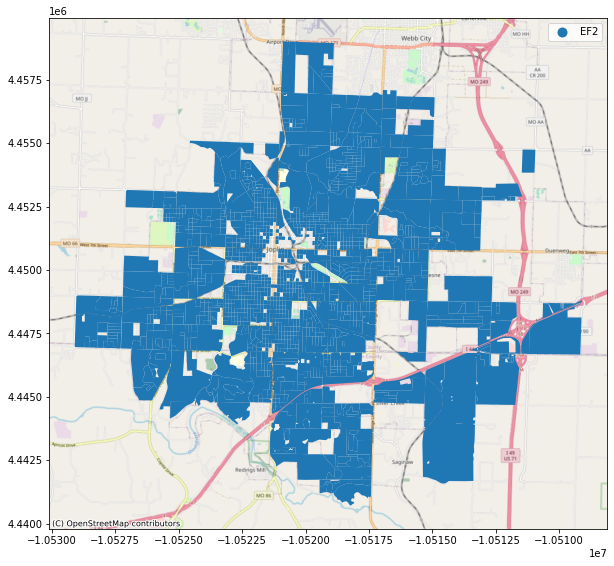

In [6]:
# Visualize the map of areas under the conditional wind speed (135mph)
tornado_path_id = "61687feae6e64611aaf192ec"
viz.plot_tornado(tornado_path_id, client, basemap=True)

In [7]:
# load csv data file
# to_do: change to read from INCORE dataset
building_stock_csv = pd.read_csv("/Users/yunjiewen/Desktop/Joplin_Analysis_paper_Part2/Tornado_simulation/IN-CORE_2ev2_SetupJoplin_FourInventories_2019-08-12_buildinginventory.csv")

In [8]:
building_stock_csv.columns

Index(['strctid', 'parid', 'blockid', 'blockidstr', 'statefp10', 'countyfp10',
       'tractce10', 'pumgeoid10', 'pumname10', 'plcgeoid10', 'plcname10',
       'address1', 'house_no', 'archtype', 'parid_card', 'struct_typ',
       'str_prob', 'no_stories', 'a_stories', 'b_stories', 'bsmt_type',
       'sq_foot', 'gsq_foot', 'occ_type', 'occ_detail', 'major_occ',
       'broad_occ', 'repl_cst', 'str_cst', 'nstra_cst', 'nstrd_cst', 'dgn_lvl',
       'cont_val', 'efacility', 'str_typ2', 'occ_typ2', 'tract_id', 'guid',
       'geometry', 'aprbldg', 'aprland', 'aprtot', 'yrblt', 'huestimate',
       'd_sf'],
      dtype='object')

In [9]:
building_stock_guid_csv = building_stock_csv[['blockid','guid','archtype']]
building_stock_guid_csv

,blockid,guid,archtype
0,290970102003000,321fbbf3-98f6-4fd1-ad1c-09ddf7b1202a,1
1,290970102003000,ee6afe29-58b8-41b5-a73e-82e75e5c6d5b,1
2,290970102003000,5f482e56-83ba-44e2-8134-63efbebd4db1,1
3,290970102003000,c8e523fe-d0e7-4b5a-a4d2-8bdfab41a927,1
4,290970102003000,068ed822-7459-4f4d-830c-4eeded119614,1
...,...,...,...
28147,291450205013028,52ad8652-269f-428f-b965-aeb38cbc6129,1
28148,290970110003000,febe8688-0a33-4505-95b9-23a43a70a16e,6
28149,290970110003000,d9db29aa-d17c-42f9-8c13-d3a715525932,6
28150,290970107001007,6775dff7-cf7f-43b3-87c0-234e2d7b430c,1


In [10]:
# take residential buildings out of building stocks
building_stock_guid_res=building_stock_guid_csv[(building_stock_guid_csv['archtype']==1)|(building_stock_guid_csv['archtype']==5)]

In [11]:
# building 'archetype' column is named as 'archtype' in some dataset in INCORE
building_stock_guid_res = building_stock_guid_res.rename(columns={'archtype':'archetype'})

In [12]:
building_stock_guid_res 

,blockid,guid,archetype
0,290970102003000,321fbbf3-98f6-4fd1-ad1c-09ddf7b1202a,1
1,290970102003000,ee6afe29-58b8-41b5-a73e-82e75e5c6d5b,1
2,290970102003000,5f482e56-83ba-44e2-8134-63efbebd4db1,1
3,290970102003000,c8e523fe-d0e7-4b5a-a4d2-8bdfab41a927,1
4,290970102003000,068ed822-7459-4f4d-830c-4eeded119614,1
...,...,...,...
28143,290970106001053,20a0f0a9-9b64-425c-97dd-6c5c7b60b9ec,1
28144,291450205012029,ff06c584-aea2-493e-851c-b23abf23f106,1
28145,290970111001015,776437fb-88b7-49f1-abce-736433fd9f1b,1
28147,291450205013028,52ad8652-269f-428f-b965-aeb38cbc6129,1


### INCORE input

In [13]:
# building mapping (with equation)
mapping_id_no_retrofit = "5d8942dfb9219c068ea795ea"  # 19 archetype without retrofit
mapping_id_with_retrofit = "618eaad5c252b35b6384378c" # 19 archetype with retrofit
#mapping_id = "60994a1906d63d5ded1d6dcc" # 19 archetype with retrofit new format mapping
fragility_service = FragilityService(client)
mapping_set_no_retrofit = MappingSet(fragility_service.get_mapping(mapping_id_no_retrofit))
mapping_set_with_retrofit = MappingSet(fragility_service.get_mapping(mapping_id_with_retrofit))

In [14]:
# Hazard information
hazard_type = "tornado"
hazard_id = "61687feae6e64611aaf192ec" # wind speed 135mph(EF2) in all residential blocks


In [15]:
# load dataframe for optimization retrofit plan 1
bldg_dataset_id = "5dbc8478b9219c06dd242c0d"  # Load the Joplin building dataset retrofit plan1
bldg_dataset= Dataset.from_data_service(bldg_dataset_id, DataService(client))
# getting geodataframework of building dataset and merge with output
bldg_gdf = bldg_dataset.get_dataframe_from_shapefile()
bldg_gdf.crs = "EPSG:4326"

In [16]:
bldg_gdf.columns

Index(['archetype', 'parid', 'struct_typ', 'year_built', 'no_stories',
       'a_stories', 'b_stories', 'bsmt_type', 'sq_foot', 'gsq_foot',
       'occ_type', 'occ_detail', 'major_occ', 'broad_occ', 'repl_cst',
       'str_cst', 'nstra_cst', 'nstrd_cst', 'dgn_lvl', 'cont_val', 'efacility',
       'dwell_unit', 'str_typ2', 'occ_typ2', 'guid', 'strctid', 'appr_bldg',
       'appr_land', 'appr_tot', 'geometry'],
      dtype='object')

In [17]:
# check the missing values on appraisal values of buildings in the dataset
bldg_gdf.appr_bldg.isna().sum()

1407

In [18]:
bldg_gdf.shape

(28152, 30)

In [19]:
# take the residential buildings' info
bldg_gdf_res = bldg_gdf[(bldg_gdf['archetype']==1) |(bldg_gdf['archetype']==5) ]
bldg_gdf_res.head(5)

,archetype,parid,struct_typ,year_built,no_stories,a_stories,b_stories,bsmt_type,sq_foot,gsq_foot,...,efacility,dwell_unit,str_typ2,occ_typ2,guid,strctid,appr_bldg,appr_land,appr_tot,geometry
0,1,P00019200310012011000,None,1925.0,None,None,None,None,None,2147,...,None,1,None,None,b497b88f-a4ba-48b1-8438-5cfc68147cfc,S0018614,93440.0,4230.0,97670.0,POINT (-94.51719 37.09726)
1,1,P00019200310012010000,None,1925.0,None,None,None,None,None,1439,...,None,1,None,None,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,S0018615,36220.0,4230.0,40450.0,POINT (-94.51716 37.09740)
2,1,P00019200310012009000,None,1925.0,None,None,None,None,None,685,...,None,0,None,None,758fb3de-108a-4e04-895e-fdc4b8627876,S0018616,38310.0,4230.0,42540.0,POINT (-94.51690 37.09756)
3,1,P00019200310012009000,None,1925.0,None,None,None,None,None,2120,...,None,1,None,None,7b706697-bf9b-4883-90f6-862d67a8e64b,S0018617,38310.0,4230.0,42540.0,POINT (-94.51712 37.09755)
4,1,P00019200310012008000,None,1900.0,None,None,None,None,None,1743,...,None,1,None,None,19c91f9b-f679-4263-b7a3-e76fd859c4b1,S0018618,42490.0,4230.0,46720.0,POINT (-94.51716 37.09768)


In [23]:
bldg_gdf_res.columns

Index(['archetype', 'parid', 'struct_typ', 'year_built', 'no_stories',
       'a_stories', 'b_stories', 'bsmt_type', 'sq_foot', 'gsq_foot',
       'occ_type', 'occ_detail', 'major_occ', 'broad_occ', 'repl_cst',
       'str_cst', 'nstra_cst', 'nstrd_cst', 'dgn_lvl', 'cont_val', 'efacility',
       'dwell_unit', 'str_typ2', 'occ_typ2', 'guid', 'strctid', 'appr_bldg',
       'appr_land', 'appr_tot', 'geometry'],
      dtype='object')

In [24]:
bldg_gdf_res.shape

(24903, 30)

In [25]:
bldg_gdf_res_appr = bldg_gdf_res[['guid','archetype','appr_bldg']]

In [26]:
# verify if two dataset have difference or not
if building_stock_guid_csv.guid.to_list() != bldg_gdf_res.guid.to_list():
    missing_guid = set(bldg_gdf_res.guid.to_list())-set(building_stock_guid_csv.guid.to_list())

In [27]:
missing_guid =  list(missing_guid)
missing_guid

['e213f6d4-ef53-4944-b7d2-f54262ec723e']

In [28]:
building_stock_guid_csv.drop_duplicates(subset=['guid'])

,blockid,guid,archtype
0,290970102003000,321fbbf3-98f6-4fd1-ad1c-09ddf7b1202a,1
1,290970102003000,ee6afe29-58b8-41b5-a73e-82e75e5c6d5b,1
2,290970102003000,5f482e56-83ba-44e2-8134-63efbebd4db1,1
3,290970102003000,c8e523fe-d0e7-4b5a-a4d2-8bdfab41a927,1
4,290970102003000,068ed822-7459-4f4d-830c-4eeded119614,1
...,...,...,...
28147,291450205013028,52ad8652-269f-428f-b965-aeb38cbc6129,1
28148,290970110003000,febe8688-0a33-4505-95b9-23a43a70a16e,6
28149,290970110003000,d9db29aa-d17c-42f9-8c13-d3a715525932,6
28150,290970107001007,6775dff7-cf7f-43b3-87c0-234e2d7b430c,1


In [29]:
# take columns "guid" and 'archetype' as new dataset
bldg_res = building_stock_guid_res.merge(bldg_gdf_res_appr,on=['guid','archetype'],how='left')

In [30]:
# check the missing values in residential buildings
bldg_res.appr_bldg.isna().sum()

920

In [31]:
# fill missing value of appraisal values
bldg_res['appr_bldg'].fillna(bldg_res['appr_bldg'].mean(),inplace = True)

In [32]:
bldg_res

,blockid,guid,archetype,appr_bldg
0,290970102003000,321fbbf3-98f6-4fd1-ad1c-09ddf7b1202a,1,43070.000000
1,290970102003000,ee6afe29-58b8-41b5-a73e-82e75e5c6d5b,1,62810.000000
2,290970102003000,5f482e56-83ba-44e2-8134-63efbebd4db1,1,96723.710462
3,290970102003000,c8e523fe-d0e7-4b5a-a4d2-8bdfab41a927,1,77220.000000
4,290970102003000,068ed822-7459-4f4d-830c-4eeded119614,1,48820.000000
...,...,...,...,...
24898,290970106001053,20a0f0a9-9b64-425c-97dd-6c5c7b60b9ec,1,72180.000000
24899,291450205012029,ff06c584-aea2-493e-851c-b23abf23f106,1,183212.000000
24900,290970111001015,776437fb-88b7-49f1-abce-736433fd9f1b,1,291290.000000
24901,291450205013028,52ad8652-269f-428f-b965-aeb38cbc6129,1,161405.000000


### building analysis without retrofit k = 0 and t = 0

In [33]:
building_dmg_result_no_retrofit, df_no_retrofit = building_damage_without_retrofit(hazard_id,mapping_set_no_retrofit)

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


In [34]:
df_no_retrofit.loc[df_no_retrofit['DS_0'] != 1][['DS_0','DS_1','DS_2','DS_3']].describe()

,DS_0,DS_1,DS_2,DS_3
count,2.694900e+04,26949.000000,26949.000000,2.694900e+04
mean,1.698654e-01,0.161790,0.148555,5.197895e-01
std,1.356998e-01,0.067558,0.088946,2.034710e-01
min,2.002000e-07,0.000611,0.002921,5.650000e-07
25%,5.433208e-02,0.111300,0.120323,3.414577e-01
50%,1.297789e-01,0.170741,0.138153,5.262427e-01
75%,2.693924e-01,0.214547,0.149392,6.973423e-01
max,4.761297e-01,0.964223,0.892410,9.923517e-01


In [35]:
building_failure_probability,df_bldg_fail= MC_building_damage(500,building_dmg_result_no_retrofit)

In [36]:
df_bldg_fail.loc[df_bldg_fail['DS_0'] != 1][['DS_0','DS_1','DS_2','DS_3']].describe()

,DS_0,DS_1,DS_2,DS_3
count,2.694900e+04,26949.000000,26949.000000,2.694900e+04
mean,1.698654e-01,0.161790,0.148555,5.197895e-01
std,1.356998e-01,0.067558,0.088946,2.034710e-01
min,2.002000e-07,0.000611,0.002921,5.650000e-07
25%,5.433208e-02,0.111300,0.120323,3.414577e-01
50%,1.297789e-01,0.170741,0.138153,5.262427e-01
75%,2.693924e-01,0.214547,0.149392,6.973423e-01
max,4.761297e-01,0.964223,0.892410,9.923517e-01


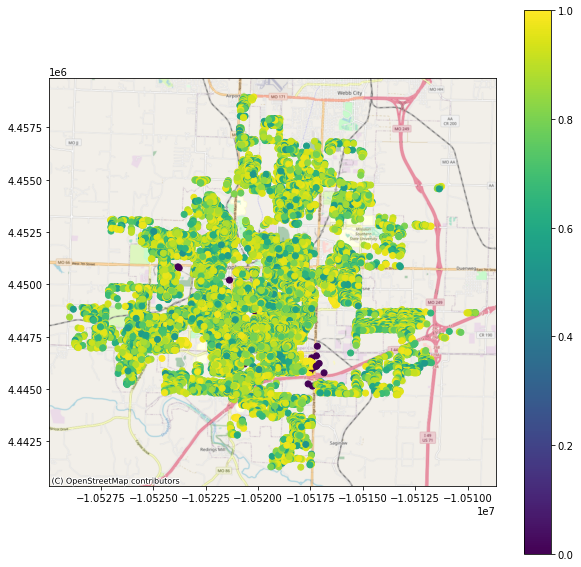

In [37]:
# getting geodataframework of building dataset and merge with output

bldg_fail_gdf = bldg_gdf_res.merge(df_bldg_fail, on='guid')
viz.plot_gdf_map(bldg_fail_gdf, column='failure_probability')

### building damage analysis with retrofit k = 2 and t = 0

In [67]:
# create retrofit strategy data INCORE file
retrofit_k2 = bldg_gdf_res[['guid']]
retrofit_k2['retrofit_method'] = 2
retrofit_k2.guid = retrofit_k2.guid.astype(str)
retrofit_k2.retrofit_method = retrofit_k2.retrofit_method.astype(str)
# guid and retrofit method are string defined by INCORE, adding quotation on both column to comply the data form
retrofit_k2.to_csv("/Users/yunjiewen/Desktop/Joplin_Analysis_paper_Part2/Tornado_simulation/Test_results/retrofit_level2.csv",
                   quoting=csv.QUOTE_ALL,index=False)
# "incore:retrofitStrategy" is INCORE data type, you can find it in source code if you don't know
retrofit_level_k2 = Dataset.from_file("/Users/yunjiewen/Desktop/Joplin_Analysis_paper_Part2/Tornado_simulation/Test_results/retrofit_level3.csv",
                          "incore:retrofitStrategy")
retrofit_level_k2

In [68]:
building_dmg_result_k2, df_building_dmg_k2 = building_damage_with_retrofit(hazard_id,mapping_set_with_retrofit,retrofit_level_k2,'k2')

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


In [69]:
df_building_dmg_k2.loc[df_building_dmg_k2['DS_0'] != 1][['DS_0','DS_1','DS_2','DS_3']].describe()

,DS_0,DS_1,DS_2,DS_3
count,2.694900e+04,26949.000000,26949.000000,2.694900e+04
mean,4.054830e-01,0.276354,0.262774,5.538907e-02
std,2.199287e-01,0.072857,0.166070,1.604400e-01
min,4.140000e-08,0.000617,0.002659,4.836000e-07
25%,2.269087e-01,0.253658,0.109427,3.266692e-03
50%,3.955457e-01,0.295949,0.238407,1.205709e-02
75%,5.960946e-01,0.324151,0.408693,3.493546e-02
max,8.499562e-01,0.964960,0.892333,9.922920e-01


In [70]:
building_failure_probability_k2,df_bldg_fail_k2= MC_building_damage(500,building_dmg_result_k2)

In [71]:
df_bldg_fail_k2.loc[df_bldg_fail_k2['DS_0'] != 1][['DS_0','DS_1','DS_2','DS_3']].describe()

,DS_0,DS_1,DS_2,DS_3
count,2.694900e+04,26949.000000,26949.000000,2.694900e+04
mean,4.054830e-01,0.276354,0.262774,5.538907e-02
std,2.199287e-01,0.072857,0.166070,1.604400e-01
min,4.140000e-08,0.000617,0.002659,4.836000e-07
25%,2.269087e-01,0.253658,0.109427,3.266692e-03
50%,3.955457e-01,0.295949,0.238407,1.205709e-02
75%,5.960946e-01,0.324151,0.408693,3.493546e-02
max,8.499562e-01,0.964960,0.892333,9.922920e-01


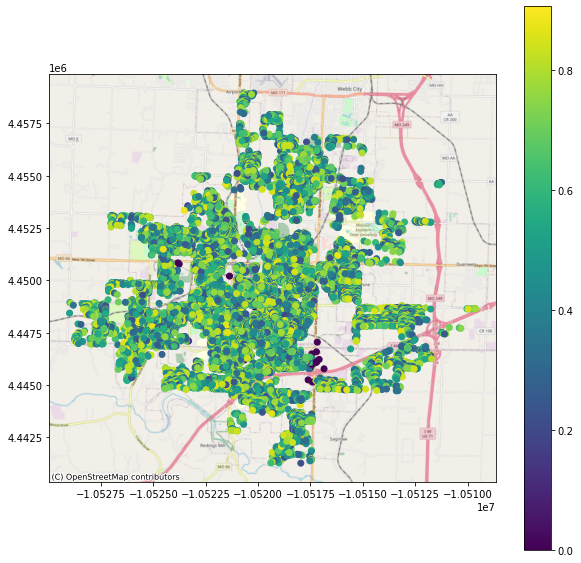

In [72]:
# getting geodataframework of building dataset and merge with output

bldg_fail_gdf_k2 = bldg_gdf_res.merge(df_bldg_fail_k2, on='guid')
viz.plot_gdf_map(bldg_fail_gdf_k2, column='failure_probability')

### building damage analysis with retrofit k = 3 and t = 0

In [53]:
retrofit_k3 = bldg_gdf_res[['guid']]
retrofit_k3['retrofit_method'] = 3
retrofit_k3.guid = retrofit_k3.guid.astype(str)
retrofit_k3.retrofit_method = retrofit_k3.retrofit_method.astype(str)
# guid and retrofit method are string defined by INCORE, adding quotation on both column to comply the data form
retrofit_k3.to_csv("/Users/yunjiewen/Desktop/Joplin_Analysis_paper_Part2/Tornado_simulation/Test_results/retrofit_level3.csv",
                   quoting=csv.QUOTE_ALL,index=False)
# "incore:retrofitStrategy" is INCORE data type, you can find it in source code if you don't know
retrofit_level_k3 = Dataset.from_file("/Users/yunjiewen/Desktop/Joplin_Analysis_paper_Part2/Tornado_simulation/Test_results/retrofit_level3.csv",
                          "incore:retrofitStrategy")
retrofit_level_k3

In [55]:
building_dmg_result_k3, df_building_dmg_k3 = building_damage_with_retrofit(hazard_id,mapping_set_with_retrofit,retrofit_level_k3,'k3')

Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...


In [56]:
building_failure_probability_k3,df_bldg_fail_k3= MC_building_damage(500,building_dmg_result_k3)

In [57]:
df_bldg_fail_k3.loc[df_bldg_fail_k3['DS_0'] != 1][['DS_0','DS_1','DS_2','DS_3']].describe()

,DS_0,DS_1,DS_2,DS_3
count,2.694900e+04,26949.000000,26949.000000,2.694900e+04
mean,4.066371e-01,0.276792,0.261487,5.508407e-02
std,2.192287e-01,0.072484,0.165399,1.604228e-01
min,3.540000e-08,0.000611,0.002067,3.199000e-07
25%,2.288664e-01,0.254743,0.109714,3.274663e-03
50%,3.989673e-01,0.296336,0.236676,1.178520e-02
75%,5.952290e-01,0.324063,0.404306,3.443653e-02
max,8.423419e-01,0.965189,0.892394,9.923443e-01


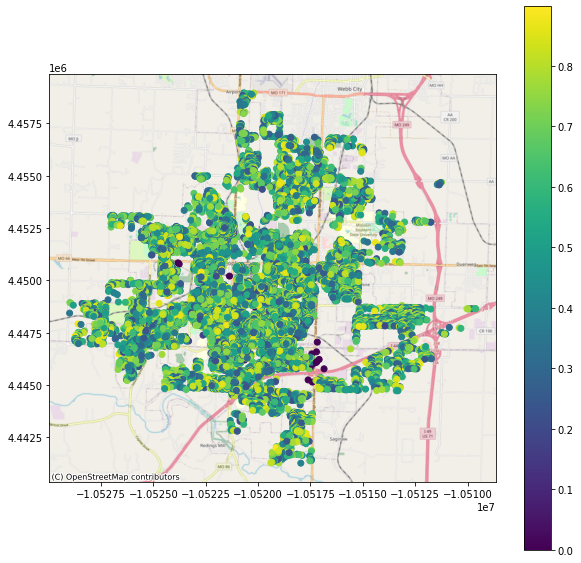

In [58]:
# getting geodataframework of building dataset and merge with output

bldg_fail_gdf_k3 = bldg_gdf_res.merge(df_bldg_fail_k3, on='guid')
viz.plot_gdf_map(bldg_fail_gdf_k3, column='failure_probability')

### Building functionality t = 0, k = 0

In [59]:
def building_functionality_recovery(df_Q0,recovery_days):
    
    # calculate Q_0
    df_Q0["Q_0"].loc[(df_Q0["Q_0"]==0)] = 0.0000001
    df_Q0["Q_0"].loc[(df_Q0["Q_0"]==1)] = 0.9999999
    
    # parameter for calculating r
    Q_t = 0.9999999
    t = 180
    
    def calculate_rijk(df_Q0):
        def rijk_function(Q_0,Q_t,t): 
        
            return  -np.log(((1/Q_t)- 1)/((1/Q_0)- 1))/t
        df_Q0["r_ijk"]=df_Q0.apply(lambda x: (rijk_function(x["Q_0"],Q_t,t)), axis=1)
        return df_Q0
    
    def calculate_Q_T_hat(df_Q0,t):
        def Q_ijk_t_function(Q_0,t,r): 
        
            return 1/(1+((1/Q_0)-1)*math.exp(-r*t))
        df_Q0["Q_t"]=df_Q0.apply(lambda x: (Q_ijk_t_function(x["Q_0"],t,x["r_ijk"])), axis=1)
        return df_Q0

    df_Q0_func = calculate_rijk(df_Q0)
    df_Q0_func = calculate_Q_T_hat(df_Q0_func,recovery_days) # calculate 15 days functionality recovery after immediate shock
    
    # functionality 
    damage_buildings = df_Q0_func[df_Q0_func['Q_0']!=1]
    functionality = damage_buildings['Q_t'].sum()/damage_buildings.shape[0]
    
    return df_Q0_func, functionality,damage_buildings.shape[0]

###  building functionality input when k = 0 and t = 0 (right after the immediate event)

In [60]:
 bldg_fail_gdf.failure_probability.mean()

0.8156862225434687

In [61]:
# merge with Joplin building stock by blockid
building_funcitonality_k0 = bldg_fail_gdf[['guid','failure_probability']]
building_funcitonality_k0['Q_0'] = 1- bldg_fail_gdf['failure_probability']
building_funcitonality_k0 = building_funcitonality_k0.merge(bldg_res,on='guid',how='left')
building_funcitonality_k0 = building_funcitonality_k0.dropna() ## one missing building from HUA dataset (id: 5dc205e4b9219c06dd2f53bc)
building_funcitonality_k0.head(5)

,guid,failure_probability,Q_0,blockid,archetype,appr_bldg
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,0.820,0.180,2.909701e+14,1.0,93440.0
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,0.958,0.042,2.909701e+14,1.0,36220.0
2,758fb3de-108a-4e04-895e-fdc4b8627876,0.570,0.430,2.909701e+14,1.0,38310.0
3,7b706697-bf9b-4883-90f6-862d67a8e64b,0.724,0.276,2.909701e+14,1.0,38310.0
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,0.972,0.028,2.909701e+14,1.0,42490.0


In [62]:
df_input_funcitonality= building_funcitonality_k0.groupby(["blockid",'archetype']).agg({"Q_0":'mean'}).reset_index()
df_input_funcitonality.blockid = df_input_funcitonality.blockid.astype(int)
df_input_funcitonality.archetype = df_input_funcitonality.archetype.astype(int)
df_Q0_k0 = copy.copy(df_input_funcitonality)
df_Q0_k0['retrofit_level'] = 0
df_Q0_k0.head(5)

,blockid,archetype,Q_0,retrofit_level
0,290970101001000,1,0.161600,0
1,290970101001001,1,0.139000,0
2,290970101001002,1,0.178500,0
3,290970101001003,1,0.138848,0
4,290970101001006,1,0.232800,0


In [63]:
df_Q0_k0.Q_0.mean()

0.189106506101966

In [64]:
bldg_fail_gdf.failure_probability.mean()

0.8156862225434687

In [65]:
df_Q0_k0.shape

(1604, 4)

### building functionality input when k = 2 and t = 0 days (right after the immediate event)

In [73]:
# merge with Joplin building stock by blockid
building_funcitonality_k2 = bldg_fail_gdf_k2[['guid','failure_probability']]
building_funcitonality_k2['Q_0'] = 1- bldg_fail_gdf_k2['failure_probability']
building_funcitonality_k2 = building_funcitonality_k2.merge(bldg_res,on='guid',how='left')
building_funcitonality_k2 = building_funcitonality_k2.dropna() ## one missing building from HUA dataset (id: 5dc205e4b9219c06dd2f53bc)
building_funcitonality_k2.head(5)

,guid,failure_probability,Q_0,blockid,archetype,appr_bldg
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,0.434,0.566,2.909701e+14,1.0,93440.0
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,0.360,0.640,2.909701e+14,1.0,36220.0
2,758fb3de-108a-4e04-895e-fdc4b8627876,0.692,0.308,2.909701e+14,1.0,38310.0
3,7b706697-bf9b-4883-90f6-862d67a8e64b,0.630,0.370,2.909701e+14,1.0,38310.0
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,0.832,0.168,2.909701e+14,1.0,42490.0


In [74]:
df_input_funcitonality_k2= building_funcitonality_k2.groupby(["blockid",'archetype']).agg({"Q_0":'mean'}).reset_index()
df_input_funcitonality_k2.blockid = df_input_funcitonality_k2.blockid.astype(int)
df_input_funcitonality_k2.archetype = df_input_funcitonality_k2.archetype.astype(int)
df_Q0_k2 = copy.copy(df_input_funcitonality_k2)
df_Q0_k2['retrofit_level'] = 2
df_Q0_k2.head(5)

,blockid,archetype,Q_0,retrofit_level
0,290970101001000,1,0.491600,2
1,290970101001001,1,0.646000,2
2,290970101001002,1,0.325000,2
3,290970101001003,1,0.494909,2
4,290970101001006,1,0.525800,2


In [75]:
df_Q0_k2.Q_0.mean()

0.442289189310354

In [76]:
bldg_fail_gdf_k2.failure_probability.mean()

0.5610041360478656

In [77]:
df_Q0_k2.shape

(1604, 4)

### building functionality input when k = 3 and t = 0 days (right after the immediate event)

In [78]:
# merge with Joplin building stock by blockid
building_funcitonality_k3 = bldg_fail_gdf_k3[['guid','failure_probability']]
building_funcitonality_k3['Q_0'] = 1- bldg_fail_gdf_k3['failure_probability']
building_funcitonality_k3 = building_funcitonality_k3.merge(bldg_res,on='guid',how='left')
building_funcitonality_k3 = building_funcitonality_k3.dropna() ## one missing building from HUA dataset (id: 5dc205e4b9219c06dd2f53bc)
building_funcitonality_k3.head(5)

,guid,failure_probability,Q_0,blockid,archetype,appr_bldg
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,0.534,0.466,2.909701e+14,1.0,93440.0
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,0.644,0.356,2.909701e+14,1.0,36220.0
2,758fb3de-108a-4e04-895e-fdc4b8627876,0.512,0.488,2.909701e+14,1.0,38310.0
3,7b706697-bf9b-4883-90f6-862d67a8e64b,0.714,0.286,2.909701e+14,1.0,38310.0
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,0.294,0.706,2.909701e+14,1.0,42490.0


In [79]:
df_input_funcitonality_k3= building_funcitonality_k3.groupby(["blockid",'archetype']).agg({"Q_0":'mean'}).reset_index()
df_input_funcitonality_k3.blockid = df_input_funcitonality_k3.blockid.astype(int)
df_input_funcitonality_k3.archetype = df_input_funcitonality_k3.archetype.astype(int)
df_Q0_k3 = copy.copy(df_input_funcitonality_k3)
df_Q0_k3['retrofit_level'] = 3
df_Q0_k3.head(5)

,blockid,archetype,Q_0,retrofit_level
0,290970101001000,1,0.528000,3
1,290970101001001,1,0.391000,3
2,290970101001002,1,0.490000,3
3,290970101001003,1,0.426485,3
4,290970101001006,1,0.426600,3


In [80]:
df_Q0_k3.Q_0.mean()

0.44525155513167314

In [81]:
bldg_fail_gdf_k3.failure_probability.mean()

0.5595751515881621

In [82]:
df_Q0_k3.shape

(1604, 4)

### building functionality input when k = 0 and t = 30 days (right after the immediate event)

In [83]:
df_Qt_input,df_input_funcitonality_30days,building_number = building_functionality_recovery(df_Q0_k0,30)

In [84]:
print ("After 30 Days recovery")
print ("Number of building damaged without retrofitting:" + str(building_number))
print ("Average building functionality with retrofitting:" + str(df_input_funcitonality_30days))

After 30 Days recovery
Number of building damaged without retrofitting:1604
Average building functionality with retrofitting:0.7933761369160957


In [85]:
df_Qt_k0 = df_Qt_input.drop(columns=['r_ijk',"Q_0"])
df_Qt_k0['retrofit_level'] = 0
print(df_Qt_k0.shape)
df_Qt_k0.head()

(1604, 4)


,blockid,archetype,retrofit_level,Q_t
0,290970101001000,1,0,0.788244
1,290970101001001,1,0,0.762542
2,290970101001002,1,0,0.804432
3,290970101001003,1,0,0.762351
4,290970101001006,1,0,0.844558


In [86]:
df_Qt_k1 = copy.copy(df_Qt_k0)
df_Qt_k1['retrofit_level'] = 1
print(df_Qt_k1.shape)
df_Qt_k1.head()

(1604, 4)


,blockid,archetype,retrofit_level,Q_t
0,290970101001000,1,1,0.788244
1,290970101001001,1,1,0.762542
2,290970101001002,1,1,0.804432
3,290970101001003,1,1,0.762351
4,290970101001006,1,1,0.844558


### building functionality input when k = 2 and t = 0 (right after the immediate event

In [87]:
df_Qt_input_k2,df_input_funcitonality_30days_k2,building_number_k2 = building_functionality_recovery(df_Q0_k2,30)
print ("After 30 Days recovery")
print ("Number of building damaged without retrofitting:" + str(building_number_k2))
print ("Average building functionality with retrofitting:" + str(df_input_funcitonality_30days_k2))

After 30 Days recovery
Number of building damaged without retrofitting:1604
Average building functionality with retrofitting:0.9204242215525168


In [88]:
df_Qt_k2 = df_Qt_input_k2.drop(columns=['r_ijk',"Q_0"])
df_Qt_k2['retrofit_level'] = 2
print(df_Qt_k2.shape)
df_Qt_k2.head()

(1604, 4)


,blockid,archetype,retrofit_level,Q_t
0,290970101001000,1,2,0.934524
1,290970101001001,1,2,0.960365
2,290970101001002,1,2,0.888675
3,290970101001003,1,2,0.935195
4,290970101001006,1,2,0.941167


### building functionality input when k = 3 and t = 0 (right after the immediate event

In [89]:
df_Qt_input_k3,df_input_funcitonality_30days_k3,building_number_k3 = building_functionality_recovery(df_Q0_k3,30)
print ("After 30 Days recovery")
print ("Number of building damaged without retrofitting:" + str(building_number_k3))
print ("Average building functionality with retrofitting:" + str(df_input_funcitonality_30days_k3))

After 30 Days recovery
Number of building damaged without retrofitting:1604
Average building functionality with retrofitting:0.9213112793279251


In [90]:
df_Qt_k3 = df_Qt_input_k3.drop(columns=['r_ijk',"Q_0"])
df_Qt_k3['retrofit_level'] = 3
print(df_Qt_k3.shape)
df_Qt_k3.head()

(1604, 4)


,blockid,archetype,retrofit_level,Q_t
0,290970101001000,1,3,0.941573
1,290970101001001,1,3,0.910283
2,290970101001002,1,3,0.934196
3,290970101001003,1,3,0.919791
4,290970101001006,1,3,0.919820


### Create funcitonality input file

In [91]:
Q_t_input = pd.concat([df_Qt_k0, df_Qt_k1,df_Qt_k2,df_Qt_k3])

In [92]:
Q_t_input = Q_t_input.sort_values(['blockid', 'archetype'], ascending=[True, False])
Q_t_input 

,blockid,archetype,retrofit_level,Q_t
0,290970101001000,1,0,0.788244
0,290970101001000,1,1,0.788244
0,290970101001000,1,2,0.934524
0,290970101001000,1,3,0.941573
1,290970101001001,1,0,0.762542
...,...,...,...,...
1602,291450206011013,1,3,0.926852
1603,291450206011020,1,0,0.829344
1603,291450206011020,1,1,0.829344
1603,291450206011020,1,2,0.922144


In [93]:
Q_t_input.shape

(6416, 4)

### Direct economic loss

In [124]:
def direct_economic_loss(building_inv,df_building_dmg):
    """
    This funciton is to estimate the direct economis loss from direct damage on buildings
    caused by tornado events
    input:
    building_inv: dataframe of original Joplin building dataset
    df_building_dmg: dataframe from building damage analysis
    
    return:
    total_building_loss: float
    df_loss: dataframe containing the direct loss info per buildings
    """
    # apply damage factor to the probability of damage state


    def p0(row):

        # insiginificant damage state

        val = (row["DS_0"] - row["DS_1"]) *0.02

        return val

    def p1(row):

        # moderate damage state

        val = (row["DS_1"] - row["DS_2"]) *0.10

        return val

    def p2(row):

        #heavy damage state

        val = (row["DS_2"] - row["DS_3"]) *0.50

        return val

    def p3(row):

         #complete damage state

        val = row["DS_3"] *1

        return val
    
    
    # apply the damage factor to the building damage state data
    df_building_dmg['Ds1_loss'] = df_building_dmg.apply(p1,axis = 1)
    df_building_dmg['Ds2_loss'] = df_building_dmg.apply(p2,axis = 1)
    df_building_dmg['Ds3_loss'] = df_building_dmg.apply(p3,axis = 1)
    df_building_dmg['Ds_total'] = df_building_dmg['Ds1_loss'] + df_building_dmg['Ds2_loss'] + df_building_dmg['Ds3_loss']
    
    # merge two dataset
    df_building_dmg = df_building_dmg.merge(building_inv, on='guid',how='left')
    df_building_dmg["loss"] = df_building_dmg['appr_bldg']*df_building_dmg['Ds_total'] 
    df_loss = df_building_dmg[['guid','blockid','archetype', 'appr_bldg', 'loss']]
    return df_building_dmg['loss'].sum(), df_loss

### Direct economic loss k= 0 and k = 1

In [125]:
loss_k0, df_loss_k0 = direct_economic_loss(bldg_res,df_no_retrofit)

In [126]:
df_loss_k0.dropna(inplace = True)
df_loss_k0.archetype = df_loss_k0.archetype.astype(int)
df_loss_k0

,guid,blockid,archetype,appr_bldg,loss
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,2.909701e+14,1,93440.0,29802.734513
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,2.909701e+14,1,36220.0,16024.606337
2,758fb3de-108a-4e04-895e-fdc4b8627876,2.909701e+14,1,38310.0,6936.235840
3,7b706697-bf9b-4883-90f6-862d67a8e64b,2.909701e+14,1,38310.0,9730.071014
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,2.909701e+14,1,42490.0,18686.420729
...,...,...,...,...,...
28147,f997af99-0124-4319-8bde-57bd4b1f521b,2.909701e+14,1,61630.0,22374.643082
28148,0d31cb6b-c16b-4ac8-ade3-a507a17a4a35,2.909701e+14,1,42390.0,13185.606759
28149,e8e4e182-dbd0-4464-9b0f-841f4f775c15,2.909701e+14,1,87830.0,24716.797652
28150,22dae85e-f4c0-4aaf-adf1-e92b769ca72d,2.909701e+14,1,47710.0,15840.878522


In [127]:
df_loss_k0_input = df_loss_k0.groupby(['blockid','archetype']).agg({'loss':'sum'}).reset_index()
df_loss_k0_input['retrofit_level'] = 0
print(df_loss_k0_input.shape)
df_loss_k0_input.head()

(1604, 4)


,blockid,archetype,loss,retrofit_level
0,2.909701e+14,1,97931.878925,0
1,2.909701e+14,1,41522.032594,0
2,2.909701e+14,1,78515.528098,0
3,2.909701e+14,1,520078.628056,0
4,2.909701e+14,1,100702.990998,0


In [128]:
f'{loss_k0:,}'

'806,179,152.9429189'

In [129]:
df_loss_k1_input = copy.copy(df_loss_k0_input)
df_loss_k1_input['retrofit_level'] = 1
print(df_loss_k1_input.shape)

(1604, 4)


### Direct Direct loss  k = 2

In [130]:
loss_k2, df_loss_k2 = direct_economic_loss(bldg_res,df_building_dmg_k2)

In [131]:
df_loss_k2.dropna(inplace = True)
df_loss_k2.archetype = df_loss_k2.archetype.astype(int)
df_loss_k2

,guid,blockid,archetype,appr_bldg,loss
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,2.909701e+14,1,93440.0,7616.277057
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,2.909701e+14,1,36220.0,2605.741263
2,758fb3de-108a-4e04-895e-fdc4b8627876,2.909701e+14,1,38310.0,7000.073605
3,7b706697-bf9b-4883-90f6-862d67a8e64b,2.909701e+14,1,38310.0,6593.939549
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,2.909701e+14,1,42490.0,10030.818659
...,...,...,...,...,...
28147,f997af99-0124-4319-8bde-57bd4b1f521b,2.909701e+14,1,61630.0,7763.599440
28148,0d31cb6b-c16b-4ac8-ade3-a507a17a4a35,2.909701e+14,1,42390.0,4686.100995
28149,e8e4e182-dbd0-4464-9b0f-841f4f775c15,2.909701e+14,1,87830.0,5501.111870
28150,22dae85e-f4c0-4aaf-adf1-e92b769ca72d,2.909701e+14,1,47710.0,6656.662395


In [132]:
df_loss_k2_input = df_loss_k2.groupby(['blockid','archetype']).agg({'loss':'sum'}).reset_index()
df_loss_k2_input['retrofit_level'] = 2
print(df_loss_k2_input.shape)
df_loss_k2_input.head()

(1604, 4)


,blockid,archetype,loss,retrofit_level
0,2.909701e+14,1,33773.284548,2
1,2.909701e+14,1,7979.614501,2
2,2.909701e+14,1,42165.372699,2
3,2.909701e+14,1,191983.600731,2
4,2.909701e+14,1,35394.600735,2


In [133]:
f'{loss_k2:,}'

'335,252,372.1647192'

### Direct Direct loss  k = 3

In [134]:
loss_k3, df_loss_k3 = direct_economic_loss(bldg_res,df_building_dmg_k3)

In [135]:
df_loss_k3.dropna(inplace = True)
df_loss_k3.archetype = df_loss_k3.archetype.astype(int)
df_loss_k3

,guid,blockid,archetype,appr_bldg,loss
0,b497b88f-a4ba-48b1-8438-5cfc68147cfc,2.909701e+14,1,93440.0,11235.271253
1,6eadcc3e-7bb5-463a-aca8-f1d16f8ac7cc,2.909701e+14,1,36220.0,5807.989647
2,758fb3de-108a-4e04-895e-fdc4b8627876,2.909701e+14,1,38310.0,4435.588716
3,7b706697-bf9b-4883-90f6-862d67a8e64b,2.909701e+14,1,38310.0,7250.387092
4,19c91f9b-f679-4263-b7a3-e76fd859c4b1,2.909701e+14,1,42490.0,1963.813556
...,...,...,...,...,...
28147,f997af99-0124-4319-8bde-57bd4b1f521b,2.909701e+14,1,61630.0,6209.280288
28148,0d31cb6b-c16b-4ac8-ade3-a507a17a4a35,2.909701e+14,1,42390.0,8163.531104
28149,e8e4e182-dbd0-4464-9b0f-841f4f775c15,2.909701e+14,1,87830.0,5304.885820
28150,22dae85e-f4c0-4aaf-adf1-e92b769ca72d,2.909701e+14,1,47710.0,7032.180581


In [136]:
df_loss_k3_input = df_loss_k3.groupby(['blockid','archetype']).agg({'loss':'sum'}).reset_index()
df_loss_k3_input['retrofit_level'] = 3
print(df_loss_k3_input.shape)
df_loss_k3_input.head()

(1604, 4)


,blockid,archetype,loss,retrofit_level
0,2.909701e+14,1,22951.615580,3
1,2.909701e+14,1,21405.835907,3
2,2.909701e+14,1,35102.086991,3
3,2.909701e+14,1,213311.895996,3
4,2.909701e+14,1,54636.028995,3


In [137]:
f'{loss_k3:,}'

'333,238,618.8380962'

### create direct loss input

In [138]:
df_loss_input = pd.concat([df_loss_k0_input,df_loss_k1_input,df_loss_k2_input,df_loss_k3_input])
df_loss_input= df_loss_input.sort_values(['blockid', 'archetype'], ascending=[True, False])
df_loss_input.blockid = df_loss_input.blockid.astype(int)
df_loss_input.head(10)

,blockid,archetype,loss,retrofit_level
0,290970101001000,1,97931.878925,0
0,290970101001000,1,97931.878925,1
0,290970101001000,1,33773.284548,2
0,290970101001000,1,22951.615580,3
1,290970101001001,1,41522.032594,0
1,290970101001001,1,41522.032594,1
1,290970101001001,1,7979.614501,2
1,290970101001001,1,21405.835907,3
2,290970101001002,1,78515.528098,0
2,290970101001002,1,78515.528098,1


In [139]:
df_loss_input.shape

(6416, 4)

### Population data

In [140]:
def population_dislocation(building_dmg_result):
    """
    This function is to calcuate the population dislocation from a troando event.
    input:
    building_dmg_result: INCORE data from building damage analysis
    Return:
    df_dislocaiton_res: dataframe of population dislocaiton results
    """
    # data input
    client.clear_cache()
    housing_unit_alloc = "5dc1c196b9219c06dd2e3f0b"
    bg_data = "5d4c9545b9219c0689b2358a"
    value_loss = "60354810e379f22e16560dbd"
    
    # Create Population dislocation analysis
    pop_dis = PopulationDislocation(client)
    
    # Load analysis input datasets
    pop_dis.load_remote_input_dataset("housing_unit_allocation", housing_unit_alloc)
    pop_dis.load_remote_input_dataset("block_group_data", bg_data)
    pop_dis.load_remote_input_dataset("value_poss_param", value_loss)
    pop_dis.set_input_dataset("building_dmg", building_dmg_result)  # Load the Joplin building damage results dataset
    
    seed = 1111
    pop_dis.set_parameter("result_name", "pop-dislocation-results")
    pop_dis.set_parameter("seed", seed)
    
    #results:
    pop_dis.run_analysis()

    # Retrieve result dataset
    dislocation_result = pop_dis.get_output_dataset("result")

    # Convert dataset to Pandas DataFrame
    df_dislocaiton = dislocation_result.get_dataframe_from_csv(low_memory=False)
    df_dislocaiton = df_dislocaiton.rename(columns = {'archtype':'archetype'})
#     print(len(list(set(df_dislocaiton.blockid))))
#     print(df_dislocaiton.shape)
    df_dislocaiton_res = bldg_res.merge(df_dislocaiton,on=('guid','archetype','blockid'),how='left')
    df_dislocaiton_res = df_dislocaiton_res[(df_dislocaiton_res['archetype']==1)|(df_dislocaiton_res['archetype']==5)]
#     print(len(list(set(df_dislocaiton_res.blockid))))
#     print(df_dislocaiton_res.shape)
    # calculate the dislocated populaiton
    populaiton_dislocaiton= df_dislocaiton_res[df_dislocaiton_res['dislocated']==True]['numprec'].sum()
    
    #print(df_dislocaiton .columns)
    return  df_dislocaiton_res

#### Retrofit level = 0

In [141]:
df_popu_dis_k0= population_dislocation(building_dmg_result_no_retrofit)


In [142]:
#df_popu_dis_k0_input = df_popu_dis_k0[df_popu_dis_k0['dislocated']==True]
df_popu_dis_k0_input = df_popu_dis_k0.groupby(['blockid','archetype']).agg({'numprec':'sum'}).reset_index()
df_popu_dis_k0_input.archetype = df_popu_dis_k0_input.archetype.astype(int)
df_popu_dis_k0_input['retroft_level'] = 0
df_popu_dis_k0_input.head()

,blockid,archetype,numprec,retroft_level
0,290970101001000,1,5.0,0
1,290970101001001,1,1.0,0
2,290970101001002,1,9.0,0
3,290970101001003,1,40.0,0
4,290970101001006,1,12.0,0


In [143]:
df_popu_dis_k0_input.numprec.sum()

53140.0

In [144]:
df_popu_dis_k1_input = copy.copy(df_popu_dis_k0_input)
df_popu_dis_k1_input['retroft_level'] = 1
print(df_popu_dis_k1_input.shape)
df_popu_dis_k1_input.head()

(1604, 4)


,blockid,archetype,numprec,retroft_level
0,290970101001000,1,5.0,1
1,290970101001001,1,1.0,1
2,290970101001002,1,9.0,1
3,290970101001003,1,40.0,1
4,290970101001006,1,12.0,1


In [145]:
len(list(set(df_popu_dis_k1_input.blockid)))

1579

In [146]:
len(list(set(df_loss_input.blockid)))

1579

#### Retrofit level = 2

In [147]:
df_popu_dis_k2 = population_dislocation(building_dmg_result_k2)
df_popu_dis_k2.head()

,blockid,guid,archetype,appr_bldg,DS_0,DS_1,DS_2,DS_3,haz_expose,strctid,...,bgyear,pblackbg,phispbg,d_sf,rploss_0,rploss_1,rploss_2,rploss_3,prdis,dislocated
0,290970102003000,321fbbf3-98f6-4fd1-ad1c-09ddf7b1202a,1,43070.000000,0.326489,0.330922,0.324183,0.018406,yes,S0000001,...,2010.0,1.286174,4.019293,1,0.003928,0.144550,0.659421,0.943769,0.429396,False
1,290970102003000,ee6afe29-58b8-41b5-a73e-82e75e5c6d5b,1,62810.000000,0.464845,0.324151,0.203225,0.007779,yes,S0000002,...,2010.0,1.286174,4.019293,1,0.005606,0.293225,0.475133,0.870053,0.383292,True
2,290970102003000,5f482e56-83ba-44e2-8134-63efbebd4db1,1,96723.710462,0.592326,0.284015,0.120337,0.003323,yes,S0000003,...,NaN,NaN,NaN,0,0.007023,0.102399,0.641858,0.936743,NaN,False
3,290970102003000,c8e523fe-d0e7-4b5a-a4d2-8bdfab41a927,1,77220.000000,0.180474,0.277747,0.493580,0.048199,yes,S0000004,...,2010.0,1.286174,4.019293,1,0.005623,0.150087,0.622040,0.928816,0.496079,True
4,290970102003000,068ed822-7459-4f4d-830c-4eeded119614,1,48820.000000,0.377156,0.333652,0.275747,0.013445,yes,S0000005,...,NaN,NaN,NaN,0,0.003609,0.266499,0.610959,0.924383,NaN,False


In [148]:
df_popu_dis_k2_input = df_popu_dis_k2[df_popu_dis_k2['dislocated']==True]
df_popu_dis_k2_input = df_popu_dis_k2_input.groupby(['blockid','archetype']).agg({'numprec':'sum'}).reset_index()
df_popu_dis_k2_input.archtype = df_popu_dis_k2_input.archetype.astype(int)
df_popu_dis_k2_input['retroft_level'] = 2
df_popu_dis_k2_input.head()

,blockid,archetype,numprec,retroft_level
0,290970101001000,1,2.0,2
1,290970101001002,1,9.0,2
2,290970101001003,1,15.0,2
3,290970101001006,1,4.0,2
4,290970101001007,1,3.0,2


In [149]:
df_popu_dis_k2_input.numprec.sum()

24239.0

#### Retrofit level = 3

In [150]:
df_popu_dis_k3 = population_dislocation(building_dmg_result_k3)
df_popu_dis_k3.head()

,blockid,guid,archetype,appr_bldg,DS_0,DS_1,DS_2,DS_3,haz_expose,strctid,...,bgyear,pblackbg,phispbg,d_sf,rploss_0,rploss_1,rploss_2,rploss_3,prdis,dislocated
0,290970102003000,321fbbf3-98f6-4fd1-ad1c-09ddf7b1202a,1,43070.000000,0.327719,0.331069,0.322946,0.018266,yes,S0000001,...,2010.0,1.286174,4.019293,1,0.003928,0.144550,0.659421,0.943769,0.428860,False
1,290970102003000,ee6afe29-58b8-41b5-a73e-82e75e5c6d5b,1,62810.000000,0.494566,0.317360,0.181642,0.006432,yes,S0000002,...,2010.0,1.286174,4.019293,1,0.005606,0.293225,0.475133,0.870053,0.375654,True
2,290970102003000,5f482e56-83ba-44e2-8134-63efbebd4db1,1,96723.710462,0.723368,0.216321,0.059142,0.001169,yes,S0000003,...,NaN,NaN,NaN,0,0.007023,0.102399,0.641858,0.936743,NaN,False
3,290970102003000,c8e523fe-d0e7-4b5a-a4d2-8bdfab41a927,1,77220.000000,0.206541,0.293327,0.460049,0.040083,yes,S0000004,...,2010.0,1.286174,4.019293,1,0.005623,0.150087,0.622040,0.928816,0.480994,True
4,290970102003000,068ed822-7459-4f4d-830c-4eeded119614,1,48820.000000,0.776901,0.181988,0.040419,0.000691,yes,S0000005,...,NaN,NaN,NaN,0,0.003609,0.266499,0.610959,0.924383,NaN,False


In [151]:
df_popu_dis_k3_input = df_popu_dis_k3[df_popu_dis_k3['dislocated']==True]
df_popu_dis_k3_input = df_popu_dis_k3_input.groupby(['blockid','archetype']).agg({'numprec':'sum'}).reset_index()
df_popu_dis_k3_input.archtype = df_popu_dis_k3_input.archetype.astype(int)
df_popu_dis_k3_input['retroft_level'] = 3
df_popu_dis_k3_input.head()

,blockid,archetype,numprec,retroft_level
0,290970101001000,1,1.0,3
1,290970101001001,1,1.0,3
2,290970101001002,1,9.0,3
3,290970101001003,1,17.0,3
4,290970101001006,1,4.0,3


In [152]:
df_popu_dis_k3_input.numprec.sum()

23565.0

### Create population dislocation input data

In [123]:
d_ijk_input = pd.concat([df_popu_dis_k0_input,df_popu_dis_k1_input,df_popu_dis_k2_input,df_popu_dis_k3_input])
d_ijk_input = d_ijk_input.sort_values(['blockid', 'archetype'], ascending=[True, False])
d_ijk_input.blockid = d_ijk_input.blockid.astype(int)
d_ijk_input 

,blockid,archetype,numprec,retroft_level
0,290970101001000,1,5.0,0
0,290970101001000,1,5.0,1
0,290970101001000,1,2.0,2
0,290970101001000,1,1.0,3
1,290970101001001,1,1.0,0
...,...,...,...,...
1452,291450206011013,1,8.0,3
1603,291450206011020,1,20.0,0
1603,291450206011020,1,20.0,1
1451,291450206011020,1,10.0,2
